Инсталација/импортирање на потребните пакети, и читање на примероците од двете класи.

In [ ]:
!pip install biopython

In [ ]:
from google.colab import files
file = files.upload()

In [ ]:
from Bio import SeqIO
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
import numpy as np
import random, operator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, GRU, Bidirectional, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import regularizers

Примероците се запишани во FASTA формат, така што си ги читаме соодветно. 

Имаме еден примерок од негативна класа со должина од 8000 а.к. - тој можеме да го отфрлиме.

In [ ]:
def parse_seqs(file):
  seqs = []
  for seq_record in SeqIO.parse(file, "fasta"):
    if len(seq_record.seq)<=5000:
      seqs.append(seq_record.seq)
  return seqs

cancerlectin_raw = parse_seqs("cancerlectin.txt")
non_cancerlectin_raw = parse_seqs("non-cancerlectin.txt")

print(len(cancerlectin_raw))
print(len(non_cancerlectin_raw))

**Анализа за должината на протеинските секвенци**


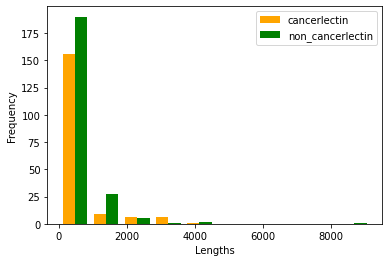

52
21
4293
9159
[(273, 4), (158, 3), (171, 3), (359, 3), (135, 2), (2033, 2), (276, 2), (195, 2), (374, 2), (357, 2)]
[(158, 3), (147, 3), (157, 3), (234, 3), (145, 2), (164, 2), (111, 2), (163, 2), (133, 2), (253, 2)]


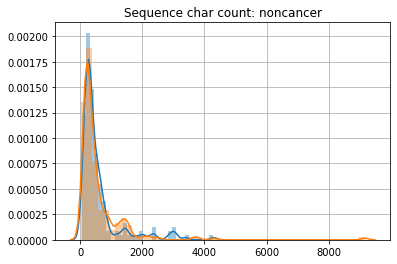

In [ ]:
lengths_cancerlectin = [len(x) for x in cancerlectin_raw]
lengths_non_cancerlectin = [len(x) for x in non_cancerlectin_raw]
legend = ['cancerlectin', 'non_cancerlectin']
plt.hist([lengths_cancerlectin, lengths_non_cancerlectin], color=['orange', 'green'])
plt.xlabel("Lengths")
plt.ylabel("Frequency")
plt.legend(legend)
plt.show()

print(min(lengths_cancerlectin))
print(min(lengths_non_cancerlectin))
print(max(lengths_cancerlectin))
print(max(lengths_non_cancerlectin))

cancer = Counter(lengths_cancerlectin)
print(cancer.most_common(10))
ncancer = Counter(lengths_non_cancerlectin)
print(ncancer.most_common(10))

def plot_seq_count(df, data_name):
  sns.distplot(df)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plot_seq_count(lengths_cancerlectin, "cancer")
plot_seq_count(lengths_non_cancerlectin, "noncancer")

# Прв пристап на енкодирање

---

Пишување на помошните променливи и функции за користење понатаму во главните.

**alphabet_to_binary** - Креираме бинарен вектор од основната азбука за дадена а.к.

**all_3mers** - Создавање на сите можни 3-пептиди од редуцираната азбука на а.к. и пакување во мапа, со клуч = пептидот и вредност = i-тата позиција(редицата) во матрицата.

**transform** - Трансформација на пептид од основната азбука во редуцираната азбука, односно секоја а.к. се заменува со соодветната група.

In [ ]:
alphabet = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, \
            "M": 10, "N": 11, "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19}

def alphabet_to_binary(ac):
  bin_vector = np.zeros((20,), dtype = "int8")
  bin_vector[alphabet[ac]] = 1
  return bin_vector

reduced_alphabet_dict = {"A":"G1", "C":"G7", "D":"G6", "E":"G6", "F":"G2", "G":"G1", "H":"G4", "I":"G2", "K":"G5", "L":"G2", \
                         "M":"G3", "N":"G4", "P":"G2", "Q":"G4", "R":"G5", "S":"G3", "T":"G3", "V":"G1", "W":"G4", "Y":"G3"}
reduced_alphabet = ["G1", "G2", "G3", "G4", "G5", "G6", "G7"]

def all_3mers():
  _3mers = {}
  count = 0
  for ac1 in reduced_alphabet:
    for ac2 in reduced_alphabet:
      for ac3 in reduced_alphabet:
        mer = ac1 + ac2 + ac3
        _3mers[mer] = count
        count += 1
  return _3mers

def transform(seq):
  mer = ""
  for ac in seq:
    mer += reduced_alphabet_dict[ac]
  return mer

**Nterminal_features** - функција што ни ја враќа бинарната репрезентација на N-терминалот(првите 10 а.к.) во вектор со димензии 1 x 200(по 20 за секоја а.к.).

**Cterminal_features** - функција што ни ја враќа бинарната репрезентација на C-терминалот(последните 10 а.к.) во вектор со димензии 1 x 200(по 20 за секоја а.к.).

**kMer_sparse_matrix_features** - функција што прво ја пресметува матрицата за дадениот протеин(редица = можниот пептид, колона = подсеквенца што се среќава во протеинот) и потоа ја редуцира до една колона со димензии 343 x 1 со користење на SVD од готовиот пакет.

In [ ]:
def Nterminal_features(seq):
  features = []
  count = 0
  for ac in seq:
    features.extend(alphabet_to_binary(ac))
    if count == 9:
      break
    count += 1
  return features

def Cterminal_features(seq):
  features = []
  for i in range(len(seq) - 10, len(seq)):#ac in seq:
    features.extend(alphabet_to_binary(seq[i]))
  return features

_3mers = all_3mers()
svd = TruncatedSVD(n_components = 1)
def kMer_sparse_matrix_features(seq):
  matrix = np.zeros((len(_3mers), len(seq) - 2), dtype = "int8")
  for i in range(0, len(seq) - 2):
    matrix[_3mers[transform(seq[i:i+3])]][i] = 1
  features = svd.fit_transform(matrix)
  return features

**transform_to_features** - функција што ги комбинира трите вектори(од N-терминал, C-терминал и од матрицата-за којшто треба дополнително транспонирање) во еден со димензии 1 x 743 за секој примерок и враќа листа од таквите трансформирани примероци. 

Се повикува за сите примероци, од двете класи.

In [ ]:
def transform_to_features(samples, length):
  seqs = np.zeros((len(samples), length))
  for i in range(0, len(samples)):
    print("Se obrabotuva pr. so dolzina " + string(len(samples[i])))
    kMer_features = np.transpose(kMer_sparse_matrix_features(samples[i]))
    kMer_features = kMer_features.tolist()[0]
    Nterminal_ftrs = Nterminal_features(samples[i])
    Cterminal_ftrs = Cterminal_features(samples[i])

    Nterminal_ftrs.extend(kMer_features)
    Nterminal_ftrs.extend(Cterminal_ftrs)

    # vo Nterminal_ftrs se naogjaat karakteristikite od trite metodi
    seqs[i] = Nterminal_ftrs
  return seqs

cancerlectin_processed = transform_to_features(cancerlectin_raw, 743)
non_cancerlectin_processed = transform_to_features(non_cancerlectin_raw, 743)



---



# Втор пристап на енкодирање

---

**integer_encoding** - функција што ни ги енкодира 20те а.к. со цел број од 1-20 и враќа низа од броеви соодветна на а.к.

Понатаму со pad_sequences додаваме 0ли на краевите на секвенците што имаат помала должина од max_length.

Од повеќе обиди за вредност на max_length, со 400 имавме навидум најдобри резултати.


In [ ]:
alphabet = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, \
            "M": 10, "N": 11, "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19}

def integer_encoding(data):
  encode_list = []
  for seq in data:
    seq_encode = []
    for ac in seq:
      seq_encode.append(alphabet[ac]+1)
    encode_list.append(np.array(seq_encode))
  
  return encode_list

cancerlectin_encode = integer_encoding(cancerlectin_raw)
non_cancerlectin_encode = integer_encoding(non_cancerlectin_raw)

# max_length = 2500
max_length = 400
cancerlectin_processed = pad_sequences(cancerlectin_encode, maxlen = max_length, padding = 'post', truncating = 'post')
non_cancerlectin_processed = pad_sequences(non_cancerlectin_encode, maxlen = max_length, padding = 'post', truncating = 'post')

print(cancerlectin_processed.shape, non_cancerlectin_processed.shape)



---



Конкатенација на примероците од двете класи и создавање на лабелите - 1 означува примерок од позитивната класа и 0 означува примерок од негативната класа. 

In [ ]:
data = np.concatenate((cancerlectin_processed, non_cancerlectin_processed))

cancerlectin_labels = np.ones((len(cancerlectin_raw),))
non_cancerlectin_labels = np.zeros((len(non_cancerlectin_raw),))
labels = np.concatenate((cancerlectin_labels, non_cancerlectin_labels))

print(data.shape)

# Градење на моделите

---

Моделите се објаснети во документацијата.

Тука ги вклучив во коментар тие за коишто имам резултати во документацијата.


In [ ]:
def training_model(data_train):
  
  # prv pristap na enkodiranje
  #x_input = Input(shape = data_train.shape[1:], name = 'input')

  # vtor pristap na enkodiranje
  x_input = Input(shape = (max_length,), name = 'input')
  # imav vo nekoi sluchai minimalno podobri rezultati bez maskiranje
  #emb = Embedding(21, 128, input_length = max_length)(x_input)
  emb = Embedding(21, 128, input_length = max_length, mask_zero = True)(x_input)
  

  # mrezha so dense sloevi
  #dense1 = Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'dense1')(x_input)
  #dense2 = Dense(372, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'dense2')(dense1)
  #dense3 = Dense(182, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'dense3')(dense2)
  #dense4 = Dense(94, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'dense4')(dense3)
  #dense5 = Dense(24, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'dense5')(dense4)
  #dense6 = Dense(12, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'dense6')(dense5)
  #reg = Dropout(0.15, name = 'regularisation')(dense6)


  # prv pristap na enkodiranje ------------------------------------------------------------------------------------------------------------------------------
  # lstm so 1 sloj
  #lstm1 = LSTM(412, return_sequences = False, recurrent_regularizer = regularizers.l2(0.01), kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'lstm1')(x_input)
  #reg = Dropout(0.15, name = 'regularisation')(lstm1)

  # lstm so poveke sloevi
  #lstm1 = LSTM(412, return_sequences = True, name = 'lstm1')(x_input)
  #lstm2 = LSTM(206, return_sequences = True, dropout = 0.15, name = 'lstm2')(lstm1)
  #lstm3 = LSTM(102, return_sequences = True, dropout = 0.15, name = 'lstm3')(lstm2)
  #lstm4 = LSTM(52, return_sequences = True, dropout = 0.15, name = 'lstm4')(lstm3)
  #lstm5 = LSTM(12, return_sequences = False, dropout = 0.15, name = 'lstm5')(lstm4)
  #reg = Dropout(0.15, name = 'regularisation')(lstm5)
  
  # gru so 1 sloj
  #gru1 = GRU(412, return_sequences = False, recurrent_regularizer = regularizers.l2(0.01), kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'gru1')(x_input)
  #reg = Dropout(0.15, name = 'regularisation')(gru1)

  # gru so poveke sloevi
  #gru1 = GRU(412, return_sequences = True, name = 'gru1')(x_input)
  #gru2 = GRU(206, return_sequences = True, dropout = 0.15, name = 'gru2')(gru1)
  #gru3 = GRU(102, return_sequences = True, dropout = 0.15, name = 'gru3')(gru2)
  #gru4 = GRU(52, return_sequences = True, dropout = 0.15, name = 'gru4')(gru3)
  #gru5 = GRU(12, return_sequences = False, dropout = 0.15, name = 'gru5')(gru4)
  #reg = Dropout(0.15, name = 'regularisation')(gru5)
  

  # vtor pristap na enkodiranje ------------------------------------------------------------------------------------------------------------------------------
  # gru so 1 sloj
  #gru1 = GRU(128, return_sequences = False, name = 'gru1')(emb)
  #reg = Dropout(0.15, name = 'regularisation')(gru1)

  # gru so poveke sloevi
  #ru1 = GRU(128, return_sequences = True, name = 'gru1')(emb)
  #gru2 = GRU(64, return_sequences = True, dropout = 0.15, name = 'gru2')(gru1)
  #gru3 = GRU(32, return_sequences = True, dropout = 0.15, name = 'gru3')(gru2)
  #gru4 = GRU(12, return_sequences = False, dropout = 0.15, name = 'gru4')(gru3)
  #reg = Dropout(0.15, name = 'regularisation')(gru4)

  # lstm so 1 sloj
  #lstm1 = LSTM(128, return_sequences = False, name = 'lstm1')(emb)
  #reg = Dropout(0.15, name = 'regularisation')(lstm1)
  
  # lstm so poveke sloevi
  #lstm1 = LSTM(128, return_sequences = True, name = 'lstm1')(emb)
  #lstm2 = LSTM(64, return_sequences = True, dropout = 0.15, name = 'lstm2')(lstm1)
  #lstm3 = LSTM(32, return_sequences = True, dropout = 0.15, name = 'lstm3')(lstm2)
  #lstm4 = LSTM(12, return_sequences = False, dropout = 0.15, name = 'lstm4')(lstm3)
  #reg = Dropout(0.15, name = 'regularisation')(lstm4)

  # bidirectional
  blstm1 = Bidirectional(LSTM(256, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01), kernel_regularizer = regularizers.l2(0.01), bias_regularizer = regularizers.l2(0.01), name = 'blstm1'))(emb)
  blstm2 = Bidirectional(LSTM(128, return_sequences = True, dropout = 0.15, name = 'blstm2'))(blstm1)
  blstm3 = Bidirectional(LSTM(64, return_sequences = True, dropout = 0.15, name = 'blstm3'))(blstm2)
  blstm4 = Bidirectional(LSTM(12, return_sequences = False, dropout = 0.15, name = 'blstm4'))(blstm3)
  reg = Dropout(0.15, name = 'regularisation')(blstm4)
  

  x_output = Dense(1, activation = 'sigmoid', name = 'pred_layer')(reg)
  model = Model(inputs = x_input, outputs = x_output)
  #model.summary()

  return model

# Тренирање и евалуација на моделите

---

Понатаму пробав 3 начини на евалуација и градење на моделите.

**Првиот начин** е поделба на множ. во тренинг, валидациско и тест мн. Првично, имаме поделба на мн. во тренинг и тест со еднаков број на примероци од двете класи во тренинг множеството. Потоа градење на модели и тестирање на тие модели со стратифицирана k-fold поделба на тренинг мн. во k тренинг и валидациски множества. На крајот користење на најдобрите модели и тестирање врз првичното тест мн. **Овој начин** откако размислив подобро, **не го користам во крајната евалуација бидејќи мн. не е доволно големо за користење на фаза на валидација**. Доколку беше соодветно големо нашето мн. овој начин би бил најдобриот за евалуација.

**Вториот начин** е исти како првиот, односно имаме поделба на мн. во тренинг и тест со еднаков број на примероци од двете класи во тренинг множеството, но овој пат без валидациско мн. и директно тестирање врз тренинг множеството. **Иако овој пат немаме валидациско мн., сепак не ги гледаме придобивките**(резултатите не беа многу поразлични од третиот начин на евалуација) **бидејќи мн. е премногу мало и резултатите зависат од изборот на примероците во тренинг мн.**

Кодот и објаснувањата за претходните два начини ги вклучив иако не ги користам при евалуација за финалните резултати во документацијата. Можат да се скокнат со соодветен избор на извршување на различни делови од кодот.

**Третиот начин што го користам за конечен метод на евалуација** е класична стратифицирана k-fold поделба во тренинг и тест мн. со понатамошна средна вредност на мерките за конечни резултати. **Овој начин е истиот што е користен во претходните истражувања и на овој начин имаме директна споредба на резултатите од претходните истражувања**.


---



**calculate_performace** - функција за пресметка на мерките за евалуација. Направено со Лапласово израмнување поради случаи кадешто потполно предвидува примероци само за едната класа.

In [ ]:
def calculate_performace(total_samples, predicted, labels):
  tp = 1
  fp = 1
  tn = 1
  fn = 1
  for index in range(total_samples):
    if labels[index] == 1:
      if labels[index] == predicted[index]:
        tp += 1
      else:
        fn += 1
    else:
      if labels[index] == predicted[index]:
        tn += 1
      else:
        fp += 1

  acc = float(tp + tn) / (total_samples + 4)
  precision = float(tp) / (tp + fp)
  sensitivity = float(tp) / (tp + fn)
  specificity = float(tn) / (tn + fp)
  MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
  return acc, precision, sensitivity, specificity, MCC

**Начин 1: k-fold со валидациско мн.**


---



Тука ја правиме поделбата во тренинг мн. со еднаков број на примероци од двете класи и тест множ. со тие примероци што остануваат. Ова резултира со 16 примероци од позитивна и 64 примероци од негативна класа во тест мн. и по 162 примероци од двете класи во тренинг мн.

Бирањето на кои примероци ќе ни бидат за тренинг е на случаен начин(со одреден seed за да имаме репродукција на резултатите).

In [ ]:
# 80% za trening, ostanato za test
split = int(0.8 * len(data))
# od tie 80% po pola za sekoja klasa
count = int(split/2)

random.seed(0)
positive_indices_training = random.sample(range(0, len(cancerlectin_labels)), count)
negative_indices_training = random.sample(range(len(cancerlectin_labels), len(labels)), count)
positive_indices_test = [x for x in range(0, len(cancerlectin_labels)) if x not in positive_indices_training]
negative_indices_test = [x for x in range(len(cancerlectin_labels), len(labels)) if x not in negative_indices_training]

train_indices = positive_indices_training
train_indices.extend(negative_indices_training)
test_indices = positive_indices_test
test_indices.extend(negative_indices_test)
random.shuffle(train_indices)
random.shuffle(test_indices)

data_train, data_test = data[train_indices], data[test_indices]
labels_train, labels_test = labels[train_indices], labels[test_indices]

Понатаму правиме k-fold поделба на тренинг мн. во тренинг и валидациско множество. 

За секој k-ти fold се зачувуваат по 3 модели, одбрани според најдобрите резултати во текот на тренирањето врз валидациското множество според мерките: загуба, точност и одзив(recall/sensitivity). Потоа со evaluate_validation за секој од тие модели добиваме конечни 3 резултати(загуба, точност и одзив) и секој резултат се зачувува во посебен dictionary.

Со други зборови, за секој k-ти fold се зачувуваат по 3 модели, односно 9 резултати - по 3 за секое од загуба, точност и одзив.

In [ ]:
def get_model_name(k, metric):
    return 'model_' + str(k) + metric + '.h5'

fold_var = 1
model = None
resDictLoss, resDictAcc, resDictRec = dict(), dict(), dict()

def evaluate_validation(fold_var, metric, data_validation, labels_validation):
  model.load_weights("/content/" + get_model_name(fold_var, metric))
  results = model.evaluate(data_validation, labels_validation)
  results = dict(zip(model.metrics_names, results))
  resDictLoss[get_model_name(fold_var, metric)] = results['loss']
  resDictAcc[get_model_name(fold_var, metric)] = results['accuracy']
  resDictRec[get_model_name(fold_var, metric)] = results['recall']


skf = StratifiedKFold(n_splits = 20, random_state = 0, shuffle = True)
for train_index, validation_index in skf.split(data_train, labels_train):
  random.shuffle(train_index)
  random.shuffle(validation_index)
  kdata_train, data_validation = data_train[train_index], data_train[validation_index]
  klabels_train, labels_validation = labels_train[train_index], labels_train[validation_index]
  
  batch = int(0.3 * len(kdata_train))
  
  # ako ideme so prviot pristap
  #kdata_train = np.reshape(kdata_train, (len(kdata_train), 1, len(kdata_train[0])))
  #data_validation = np.reshape(data_validation, (len(data_validation), 1, len(data_validation[0])))

  model = training_model(kdata_train)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall(name = "recall")])
  #print("Treniranje na modelot")
  checkpointAcc = ModelCheckpoint("/content/" + get_model_name(fold_var, 'acc'), monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode='max')
  checkpointLoss = ModelCheckpoint("/content/" + get_model_name(fold_var, 'loss'), monitor = 'val_loss', verbose = 1, save_best_only = True, mode='min')
  checkpointRec = ModelCheckpoint("/content/" + get_model_name(fold_var, 'rec'), monitor = 'val_recall', verbose = 1, save_best_only = True, mode='max')
  #es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
  model.fit(kdata_train, klabels_train, batch_size = batch, epochs = 45, callbacks = [checkpointAcc, checkpointLoss, checkpointRec], validation_data=(data_validation, labels_validation))

  evaluate_validation(fold_var, 'acc', data_validation, labels_validation)
  evaluate_validation(fold_var, 'loss', data_validation, labels_validation)
  evaluate_validation(fold_var, 'rec', data_validation, labels_validation)
  
  fold_var += 1

Се зема најдобриот модел за секоја од мерките и се тестираат на првичното тест множество.

In [ ]:
def testing_model(name, data_test, labels_test):
    batch = int(0.2 * len(data_test))
    data_test = np.reshape(data_test, (len(data_test), 1, len(data_test[0])))

    model.load_weights("/content/" + name)
    probs = model.predict(data_test, batch_size = batch)
    predicted_labels = []
    for prob in probs:
      if prob >= 0.5:
        predicted_labels.append(1)
      else:
        predicted_labels.append(0)

    acc, precision, sensitivity, specificity, MCC = calculate_performace(len(data_test), predicted_labels, labels_test)
    print('''Evaluacija so test mn. za modelot "%s"''' % name)
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", sensitivity)
    print("Specificity:", specificity)
    print("MCC:", MCC)

In [ ]:
modelLoss = min(resDictLoss.items(), key = operator.itemgetter(1))[0]
modelAcc = max(resDictAcc.items(), key = operator.itemgetter(1))[0]
modelRec = max(resDictRec.items(), key = operator.itemgetter(1))[0]
print(modelLoss)
print(modelAcc)
print(modelRec)

testing_model(modelLoss, data_test, labels_test)
testing_model(modelAcc, data_test, labels_test)
testing_model(modelRec, data_test, labels_test)

model_1loss.h5
model_1acc.h5
model_12acc.h5
Evaluacija so test mn. za modelot "model_1loss.h5"
Accuracy: 0.6790123456790124
Precision: 0.3548387096774194
Recall: 0.6470588235294118
Specificity: 0.6875
MCC: 0.2802987021533323
Evaluacija so test mn. za modelot "model_1acc.h5"
Accuracy: 0.7407407407407407
Precision: 0.4375
Recall: 0.8235294117647058
Specificity: 0.71875
MCC: 0.45171502336642955
Evaluacija so test mn. za modelot "model_12acc.h5"
Accuracy: 0.6296296296296297
Precision: 0.3142857142857143
Recall: 0.6470588235294118
Specificity: 0.625
MCC: 0.2236476429047173




---



**Начин 2: тренирачко & тест мн.**


---



In [ ]:
batch = int(0.15 * len(data_train))
# ako ideme so prviot pristap
#data_train = np.reshape(data_train, (len(data_train), 1, len(data_train[0])))

model = training_model(data_train)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#print("Treniranje na modelot")
model.fit(data_train, labels_train, batch_size = batch, epochs = 45)

batch = int(0.25 * len(data_test))
# ako ideme so prviot pristap
#data_test = np.reshape(data_test, (len(data_test), 1, len(data_test[0])))

probs = model.predict(data_test, batch_size = batch)
predicted_labels = []
for prob in probs:
  if prob >= 0.5:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)

# gledav kakvi verojatnosti se dobivaat - najchesto e so golema verojatnost
# i koga predviduva greshno i koga predviduva tochno.
#listt = []
#for i in range(len(probs)):
  #listt.append([probs[i], predicted_labels[i], labels_test[i]])
#print(listt)

acc, precision, sensitivity, specificity, MCC = calculate_performace(len(data_test), predicted_labels, labels_test)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", sensitivity)
print("Specificity:", specificity)
print("MCC:", MCC)



---



**Начин 3: без валидациско мн. - како во претходните истражувања и тоа што го користам во конечните резултати**


---

Се дели секој пат со еднаква распределба на класите во тренинг и тест множеството, се евалуира изградениот модел врз тест множеството и на крајот се зема средната вредност од сите резултати.

In [ ]:
res = []

skf = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True)
for train_index, test_index in skf.split(data, labels):
  # pravime obichen shuffle za da ne se podredeni pozitivni, pa negativni, bidejki ima 
  # vlijanie vrz toa kako uchi mrezhata
  random.shuffle(train_index)
  random.shuffle(test_index)
  data_train, data_test = data[train_index], data[test_index]
  labels_train, labels_test = labels[train_index], labels[test_index]
  
  batch = int(0.2 * len(data_train))
  # dokolku odime so prviot pristap
  #data_train = np.reshape(data_train, (len(data_train), 1, len(data_train[0])))
  #data_test = np.reshape(data_test, (len(data_test), 1, len(data_test[0])))

  model = training_model(data_train)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.fit(data_train, labels_train, batch_size = batch, epochs = 50)

  batch = int(0.2 * len(data_test))
  probs = model.predict(data_test, batch_size = batch)
  predicted_labels = []
  for prob in probs:
    if prob >= 0.5:
      predicted_labels.append(1)
    else:
      predicted_labels.append(0)

  acc, precision, sensitivity, specificity, MCC = calculate_performace(len(labels_test), predicted_labels, labels_test)
  results = []
  print("Accuracy:", acc)
  print("Precision:", precision)
  print("Recall:", sensitivity)
  print("Specificity:", specificity)
  print("MCC:", MCC)
  results.append(acc)
  results.append(precision)
  results.append(sensitivity)
  results.append(specificity)
  results.append(MCC)
  res.append(results)

In [ ]:
def results(res_by_metric):
  acc, precision, recall, specificity, MCC = [], [], [], [], []
  for res in res_by_metric:
    acc.append(res[0])
    precision.append(res[1])
    recall.append(res[2])
    specificity.append(res[3])
    MCC.append(res[4])
  print(acc)
  print(precision)
  print(recall)
  print(specificity)
  print(MCC)
  print("Accuracy:", np.mean(acc))
  print("Precision:", np.mean(precision))
  print("Recall:", np.mean(recall))
  print("Specificity:", np.mean(specificity))
  print("MCC:", np.mean(MCC))

results(res)



---

